# Labeling Objects from Pictures with Convolutional Neural Networks

### Author: Salvatore Porcheddu
### Date: 19/05/2022


## Introduction

This is a practice computer vision project where we will try to build a **Convolutional Neural Network (CNN)** that can correctly label what is in the pictures in the famous **CIFAR-10** dataset with at least 75% accuracy. 

The **CIFAR-10** dataset contains a total of 60,000 images belonging to ten different classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. 
While it can be downloaded directly in a suitable format within the deep learning library *Keras* (which is part of *TensorFlow*), in this project we will download it from the [original source](https://www.cs.toronto.edu/~kriz/cifar.html) and make it suitable for proper use with *Keras* ourselves.

To learn more about the CIFAR-10 dataset please read "**Learning Multiple Layers of Features from Tiny Images**", published by **Alex Krizhevsky** in 2009, that can be found [here](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).

In [14]:
# importing relevant packages, deactivating warnings

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras import models, layers, preprocessing, callbacks, utils
from tensorflow import random
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Preparing the data

The CIFAR-10 dataset comes in six serialized batches of 10,000 images each; five of them are to be used for training and the other one for testing.

Before we can do anything with the data, we will need to deserialize it:

In [15]:
# defining function to load serialized files containing the images

def deserializer(filename):
    """This function takes a filename, opens the corresponding file, 
    performs deserialization and finally returns the deserialized file.
    
    Args:
    filename: string corresponding to the name of the file to be deserialized.
    
    Returns:
    deserialized file."""
    
    with open(filename, "rb") as f:
        file = pickle.load(f, encoding="bytes")
    return file

In [16]:
# defining file names

batch_names = [f"data_batch_{n}" for n in range(1, 6)]
labs = "batches.meta"

In [17]:
# loading files and labels

batches = [deserializer(b) for b in batch_names]

labels = deserializer(labs)

test = deserializer("test_batch")

Each of the batches is a dictionary containing arrays for each picture and the corresponding labels. We will later merge the batches together and let *Keras* do the batching work. 

In [18]:
# examining the batches

batches[0][b"data"].shape

(10000, 3072)

As the [documentation](https://www.cs.toronto.edu/~kriz/cifar.html) explains, there are 10,000 32x32 pictures, with 1024 entries for each of the RGB channels. 
The image is stored in row-major order, which means that the rgb channels are ordered by row (each row contains data related to one of the channels).
The data needs to be reshaped in order to be correctly fed to a *Keras* convolutional neural network. 

The reshaping process will entail the following steps:

- Splitting the data thereby separating the three channels. 
- Reshaping each channel data to the image shape of 32x32.
- Restacking the channel data together making sure that it is the right format (each element, which corresponds to a pixel, must have three values, one for the red channel, one for the green channel and one for the blue channel).

In [19]:
# merging the arrays and creating a validation dataset

X_train = []
y_train = []
X_val = []
y_val = []

for b in batches:
    if b != batches[-1]:
        X_train.append(b[b"data"])
        y_train.append(b[b"labels"])
    else:
        X_val.append(b[b"data"])
        y_val.append(b[b"labels"])
    
X_train, y_train = np.array(X_train, dtype="uint8"), np.array(y_train, dtype="uint8")
X_val, y_val = np.array(X_val, dtype="uint8"), np.array(y_val, dtype="uint8") 

X_train.shape

(4, 10000, 3072)

In [20]:
# creating a function that reshapes the data to the correct format

def rgb_reshaper(data, n_batches=1):
    """This function takes the deserialized image data from the CIFAR-10 dataset and performs array 
    transformations to convert it into rgb data.
    
    Args:
    data: numpy array containing image data.
    n_batches: integer referring to the number of the original CIFAR-10 batches that 'data' contains. 
               This value will be used for reshaping 'data' and defaults to 1.
               
    Returns:
    Numpy array with rgb data."""
    
    r, g, b = np.split(data, 3, axis=2) # splits the data into separate arrays for each channel
    r = r.reshape((10000*n_batches, 32, 32))
    g = g.reshape((10000*n_batches, 32, 32))
    b = b.reshape((10000*n_batches, 32, 32))
    rgb = np.stack([r, g, b], axis=3) # stacks the channel arrays together
    return rgb

In [21]:
# executing the reshapes for training and validation data

X_train = rgb_reshaper(X_train, 4)
X_val = rgb_reshaper(X_val)

Reshaping the data in this way allows us to visualize the images with *matplotlib*:

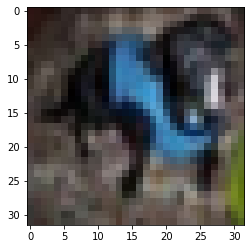

In [22]:
plt.imshow(X_train[27])
plt.show()

The labels need less reshaping work but they need to be transformed into binary class matrices so that *Keras* will correctly recognize that there are ten different classes when we train the network.

In [23]:
y_train = utils.to_categorical(y_train.reshape((10000*4)), 10) 
y_val = utils.to_categorical(y_val.reshape((10000)), 10)

y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [24]:
# creating the test dataset

X_test = rgb_reshaper(test[b"data"].reshape((1, 10000, -1)))
y_test = utils.to_categorical(np.array(test[b"labels"], dtype="uint8"), 10)

X_test.shape

(10000, 32, 32, 3)

## Building and training the network

Before building the network, we will perform three preliminary steps:

- Setting *random seeds* so that every time that we run the code we get the same results.
- Building an image data generator that takes our images and performs manipulation of various kinds (e.g. rotation, zooming...) in order to generate more images to be used together with the original ones for training and validation. This method is very useful so that our model does not *overfit* (i.e. memorizes the training data without being able to generalize to new and unseen data).
- Creating an early stopping *callback*, which allows us to stop the training of the network if performance is not improving within a certain number of epochs.

In [25]:
# setting random seeds

np.random.seed(27)
random.set_seed(27)

# augmenting training and validation data

generator = preprocessing.image.ImageDataGenerator(rotation_range=.2, zoom_range=.2, shear_range=.2, horizontal_flip=True)
aug_train = generator.flow(X_train, y_train)
aug_val = generator.flow(X_val, y_val)

# creating a callback to stop training if there are no improvements in the validation accuracy within 20 consecutive epochs

early_stop = callbacks.EarlyStopping(monitor="val_accuracy", patience=20)

Now we can proceed to build, compile and train a CNN. 

The training will last 100 epochs unless it is interrupted for lack of improvement by the early stopping callback we have just created. 

For each epoch of training, performance will be tested on both the training set and on the previously created validation set.

In [26]:
# building and fitting a CNN

CNN = models.Sequential()
CNN.add(layers.Conv2D(128, 2, 2, activation="relu", input_shape=(32, 32, 3)))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Conv2D(256, 2, 2, activation="relu"))
CNN.add(layers.MaxPool2D(2))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Conv2D(128, 2, 2, activation="relu"))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Flatten())
CNN.add(layers.Dense(256, activation="relu"))
CNN.add(layers.Dropout(.2))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Dense(128, activation="relu"))
CNN.add(layers.Dropout(.1))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Dense(128, activation="relu"))
CNN.add(layers.Dropout(.1))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Dense(64, activation="relu"))
CNN.add(layers.BatchNormalization())
CNN.add(layers.Dense(10, activation="softmax"))

CNN.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = CNN.fit(aug_train, validation_data=aug_val, epochs=100, shuffle=False, verbose=1, callbacks=early_stop)

Epoch 1/100
1250/1250 [==============================] - 25s 19ms/step - loss: 1.6950 - accuracy: 0.3927 - val_loss: 1.4442 - val_accuracy: 0.4836
Epoch 2/100
1250/1250 [==============================] - 22s 17ms/step - loss: 1.3772 - accuracy: 0.5076 - val_loss: 1.4466 - val_accuracy: 0.4933
Epoch 3/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.2533 - accuracy: 0.5569 - val_loss: 1.2083 - val_accuracy: 0.5685
Epoch 4/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.1773 - accuracy: 0.5876 - val_loss: 1.1403 - val_accuracy: 0.5985
Epoch 5/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.1140 - accuracy: 0.6108 - val_loss: 1.0283 - val_accuracy: 0.6318
Epoch 6/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.0699 - accuracy: 0.6265 - val_loss: 1.0026 - val_accuracy: 0.6449
Epoch 7/100
1250/1250 [==============================] - 23s 18ms/step - loss: 1.0258 - accuracy: 0.6411 - val_loss: 0

In [27]:
# printing best scores

max_acc = max(history.history["accuracy"]) 
max_val_acc = max(history.history["val_accuracy"]) 

print(f"The network reached a maximum training accuracy of {round(max_acc * 100, 2)}% \
at epoch {history.history['accuracy'].index(max_acc) + 1} and a maximum validation accuracy of \
{round(max_val_acc * 100, 2)}% at epoch {history.history['val_accuracy'].index(max_val_acc) + 1}.")

The network reached a maximum training accuracy of 83.46% at epoch 98 and a maximum validation accuracy of 76.58% at epoch 90.


Finally, after training the network we evaluate its performance on the test set: this will give us a definitive idea of how well the network performs when it is presented with image data that has never seen before.

In [28]:
# Evaluating network performance on the test set

scores = CNN.evaluate(X_test, y_test)

print(f"\nThe network scored {round(scores[1] * 100, 2)}% accuracy on the test set.")

313/313 [==============================] - 2s 6ms/step - loss: 0.7433 - accuracy: 0.7609

The network scored 76.09% accuracy on the test set.


## Conclusion

The CNN that we built can correctly label the pictures from the CIFAR-10 dataset more than 75% of the time. There was no strong signal of *overfitting* during training, which means that by building a more complex network a better score could be obtained; however, this would require more computational power.